# 0. Loading packages

Uncomment cell below if not all necessary packages are installed

In [1]:
# Install necessary packages
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn
# %pip install missingno
# %pip install imblearn
# %pip install xgboost
# %pip install statsmodels

In [2]:
import warnings
warnings.filterwarnings('ignore')

import functions as fc

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Loading data

In [3]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')

test_data_pred_col = list(test_data['date_hour'])

# 2. Inspecting data

## 2.1 Showing datasets

In [4]:
train_data.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [6]:
train_data.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


The datasets contains no missing data.

The columns in the dataset are predominantly of data types `int` or `float`, except for the `date_hour` column, which is of type `object`. This column will need to be converted to the `datetime` format for further analysis.

## 2.2 Inspecting individual columns

In [7]:
cols = ['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

dv_train = fc.DataVisualizer(train_data)

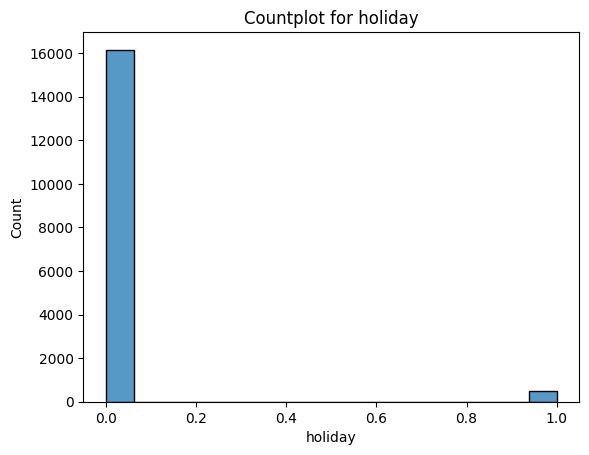

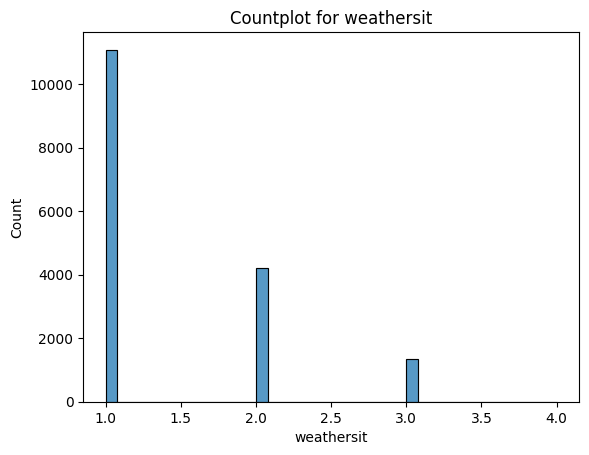

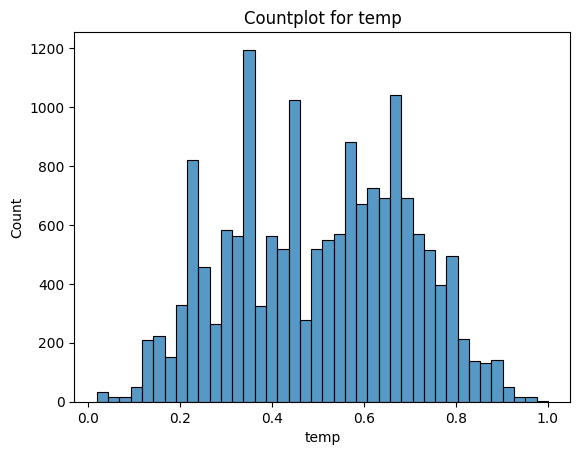

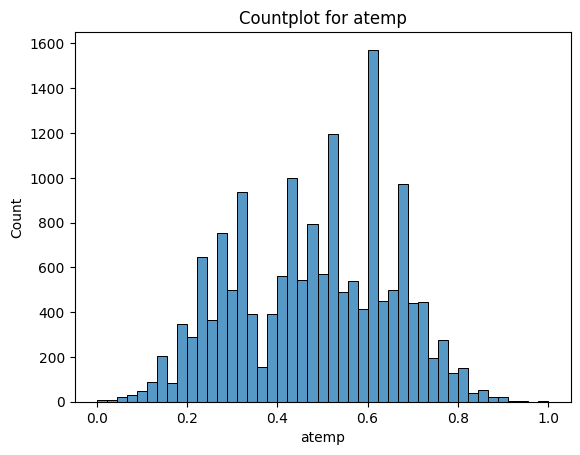

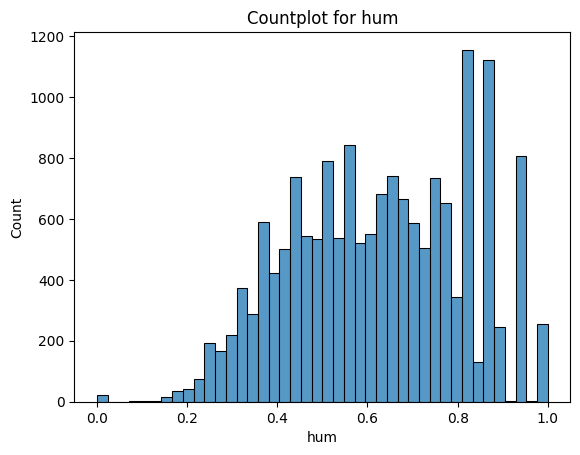

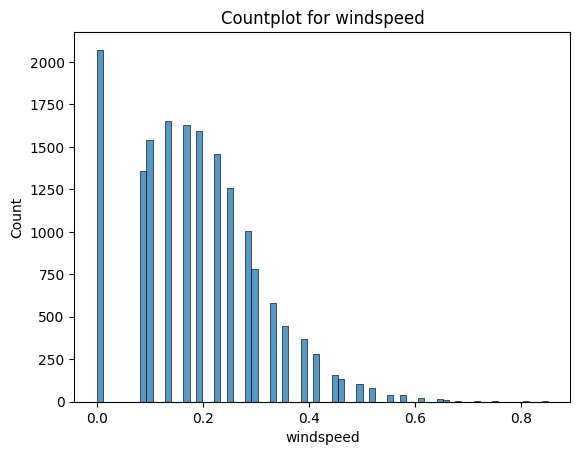

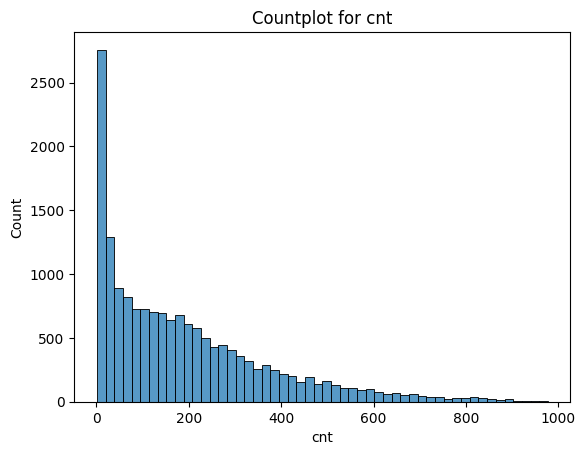

In [8]:
dv_train.plot_distribution(cols, 'train_data')

1. **Countplot for `holiday`:**
    - **Majority of entries are non-holidays**: The count for `0` (non-holidays) is significantly higher than `1` (holidays), indicating that most of the data represents regular working or non-holiday days.
2. **Countplot for `weathersit`:**
    - **Category 1 dominates**: Most observations fall into category `1`, representing favorable or clear weather.
    - **Category 2 and 3 are less common**: These represent moderate or less favorable weather conditions.
    - **Category 4 is absent**: These imply extreme weather conditions are not present in the dataset.
3. **Countplot for `temp`:**
    - This column is normally distributed.
4. **Countplot for `atemp`:**
    - This column is normally distributed.
5. **Countplot for `hum`:**
    - This column is left skewed.
6. **Countplot for `windspeed`:**
    - This column is right skewed.
7. **Countplot for `cnt`:**
    - Most of the amounts for cnt are nearer to zero, indicating that higher amounts for `cnt` are preserved for specific occassions.

## 2.3 Relationships between variables

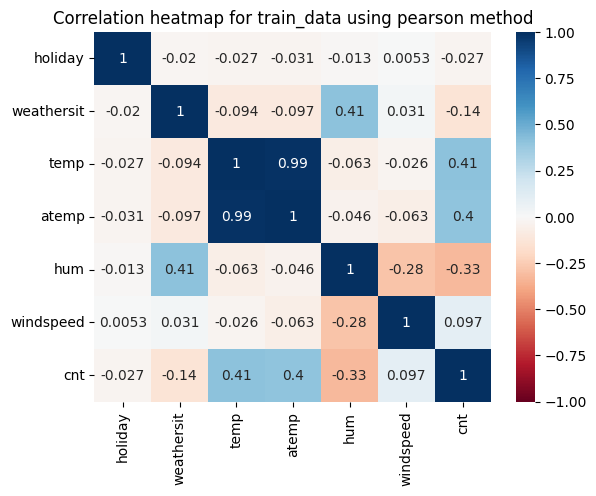

In [9]:
dv_train.plot_correlation('train_data', method='pearson')

The target variable `cnt` exhibits the following correlations with the other features in the dataset:

1. **`temp` (Temperature)**:
   - Correlation: **0.41** (moderate positive)
   - Interpretation: As temperature increases, the count of rentals tends to increase. This suggests that warmer weather is favorable for usage.

2. **`atemp` (Feels-like Temperature)**:
   - Correlation: **0.4** (moderate positive)
   - Interpretation: Similar to `temp`, higher feels-like temperatures are associated with more rentals. Since `temp` and `atemp` are highly correlated with each other, their impact on `cnt` is quite similar.

3. **`hum` (Humidity)**:
   - Correlation: **-0.33** (moderate negative)
   - Interpretation: Higher humidity levels are associated with a decrease in rentals. This indicates that humid weather may discourage people from renting.

4. **`windspeed`**:
   - Correlation: **0.097** (weak positive)
   - Interpretation: Windspeed shows a very weak positive correlation with rentals. This suggests that windspeed has a minimal linear relationship with the count of rentals.

5. **`weathersit` (Weather Situation)**:
   - Correlation: **-0.14** (weak negative)
   - Interpretation: Since this column is a column consisting of four classes, a pearson correlation coefficient is not the best way to figure out relations.

6. **`holiday`**:
   - Correlation: **-0.027** (very weak negative)
   - Interpretation: The correlation between holidays and rentals is negligible, indicating that the number of rentals is not significantly affected by whether it is a holiday. Although, here again it is a column consisting of two classes, therefore, a pearson correlation coefficient is not the best way to find out relations.

**Summary:**
- The most significant predictors of `cnt` are `temp` (0.41), `atemp` (0.4), and `hum` (-0.33), as these exhibit moderate correlations.
   - Since `temp` and `atemp` have a high correlation towards eachothter (0.99), one of them can be rendered negligible.
- Features such as `windspeed`, `weathersit`, and `holiday` show weak or negligible correlations, indicating they may have limited linear influence on the target variable.

## 2.4 Inspecting trends, and seasonal components

**Time Series Decomposition**

In time series analysis, we assume an additive decomposition model where the data can be expressed as:

$$y_t = S_t + T_t + R_t$$

Where:
- **$y_t$**: The observed data at time $t$  
- **$S_t$**: The seasonal component at time $t$  
- **$T_t$**: The trend component at time $t$  
- **$R_t$**: The residual (or irregular) component at time $t$  
*(Hyndman & Athanasopoulos, 2018)*  


**Insights from Decomposition Components**

Decomposing the time series into its primary components provides valuable insights:

1. **Trend**:  
   The trend represents the long-term movement in the data. It reveals whether the overall direction of the data is increasing, decreasing, or stable. Short-term fluctuations are ignored as they may result from noise or temporary anomalies.

2. **Seasonality**:  
   The seasonality captures periodically repeating patterns in the data. These patterns occur at consistent intervals, such as daily, weekly, or annually, and reflect regular cyclical behavior.

3. **Residuals**:  
   The residuals represent the irregular component of the data. These are deviations that cannot be explained by either the trend or the seasonality, such as unexpected peaks or outliers.  
   *(Dey, 2024)*


In [10]:
train_dc = fc.TimeSeriesDecomposer(train_data['cnt'], period=24)

In [11]:
trend, seasonal, residual = train_dc.decompose()

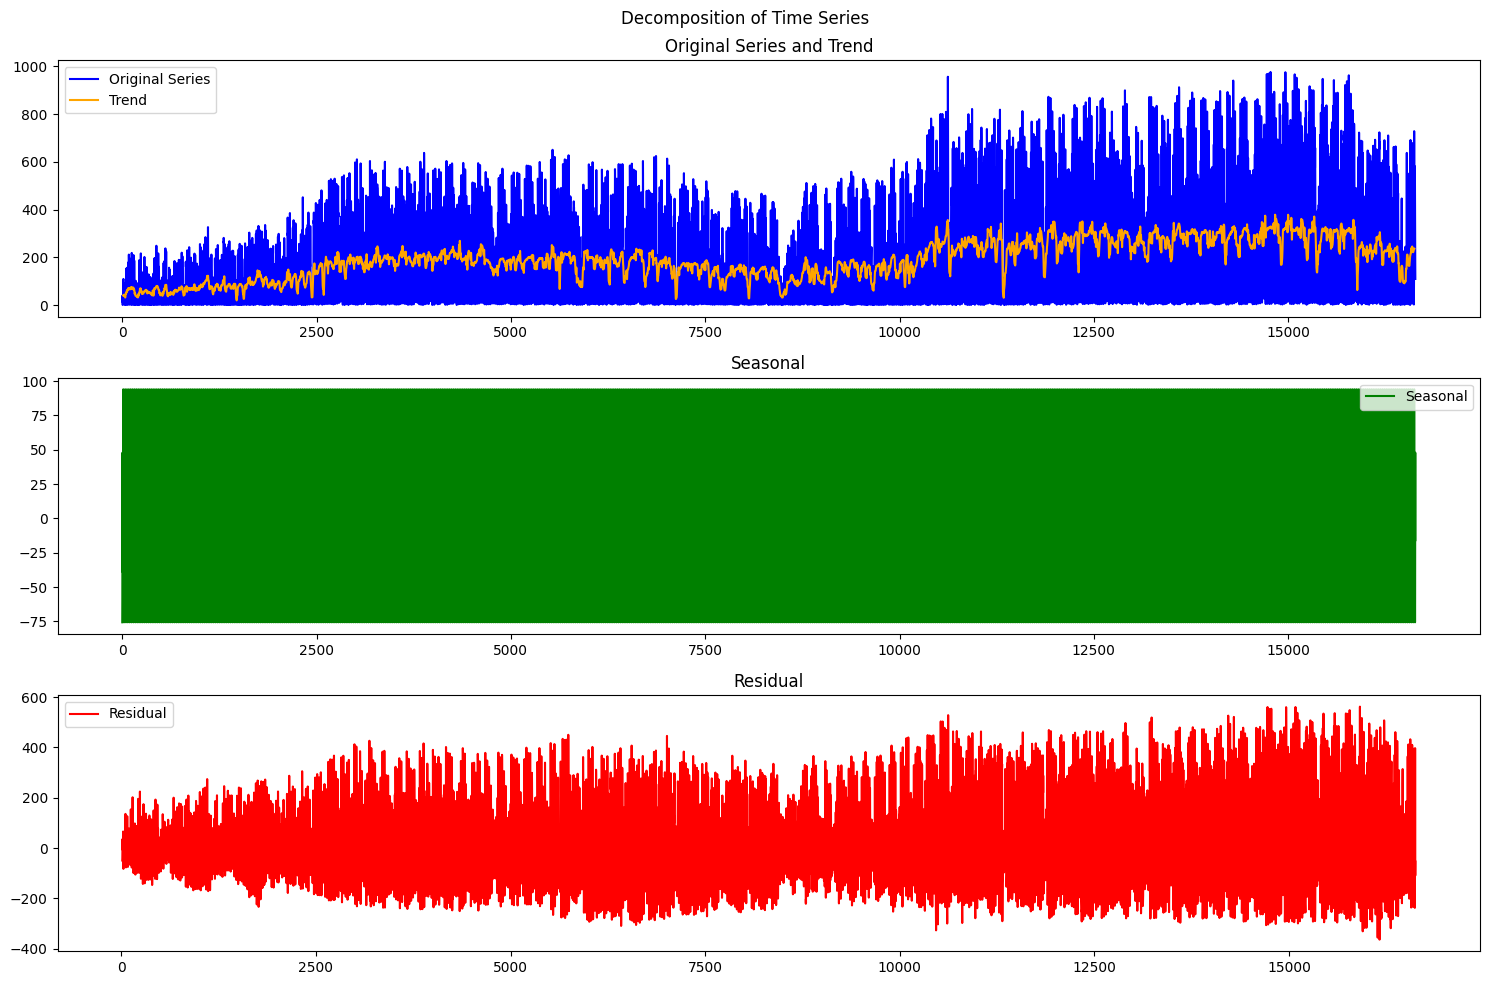

In [12]:
train_dc.plot_decomposition(trend, seasonal, residual)

The plot above does not clearly reveal a seasonally repeating pattern, it is currently commented out due to runtime. This is likely due to the extensive amount of data, as it encompasses hourly observations over a two-year period. To facilitate the identification of seasonal patterns, a new decomposition will be performed on a subset comprising one-thirtysecond of the dataset.


In [13]:
train_dc_1 = fc.TimeSeriesDecomposer(train_data.iloc[:int(len(train_data)/32), :]['cnt'], period=24)

In [14]:
trend, seasonal, residual = train_dc_1.decompose()

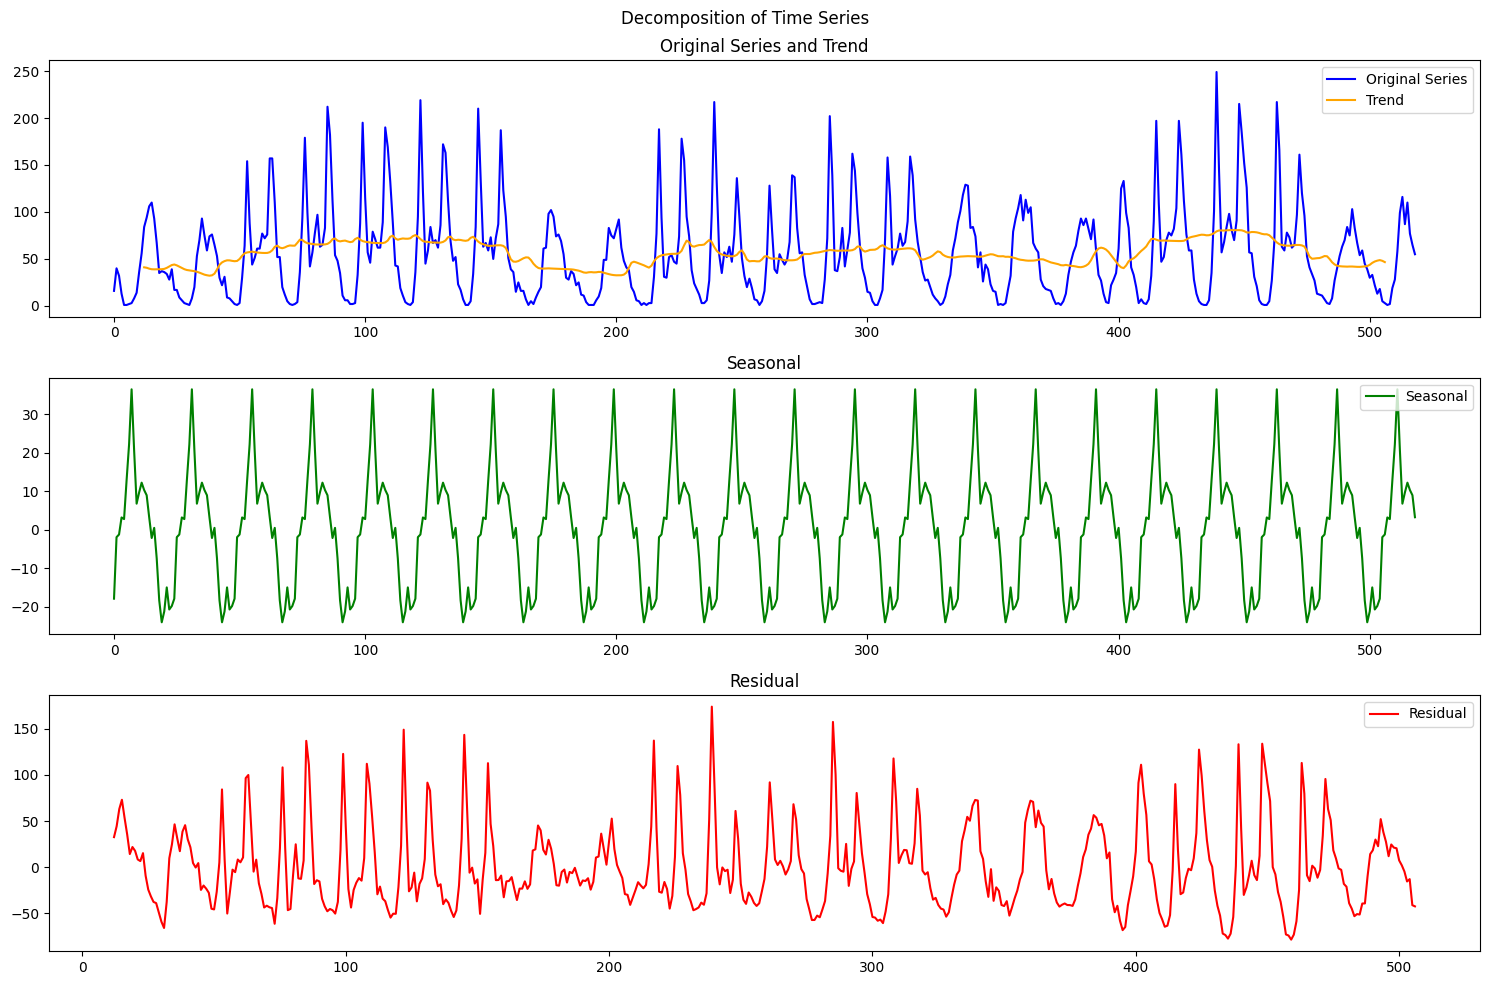

In [15]:
train_dc_1.plot_decomposition(trend, seasonal, residual)

The plot above indicates a distinct **seasonal pattern** with a periodicity of approximately **one day**, suggesting a temporal influence on the **`cnt`** variable. However, there is no apparent trend in the data, which suggests that the dataset may already be stationary. This assumption will be further tested using the **Augmented Dickey-Fuller (ADF) test** in subsequent analysis.  

## 2.5 Inspecting time specific relations

To validate the presence of daily seasonal patterns, visualizations will be created using different time elements (e.g., hour, day, week) on the x-axis and the target variable on the y-axis. These plots will help to identify and observe visible trends or repeating patterns over time.

In [16]:
train_data = fc.create_timeseries_features(train_data)

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_hour    16637 non-null  datetime64[ns]
 1   holiday      16637 non-null  int64         
 2   weathersit   16637 non-null  int64         
 3   temp         16637 non-null  float64       
 4   atemp        16637 non-null  float64       
 5   hum          16637 non-null  float64       
 6   windspeed    16637 non-null  float64       
 7   cnt          16637 non-null  int64         
 8   year         16637 non-null  int64         
 9   month        16637 non-null  int64         
 10  week         16637 non-null  int64         
 11  day          16637 non-null  int64         
 12  hour         16637 non-null  int64         
 13  day_of_week  16637 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 1.8 MB


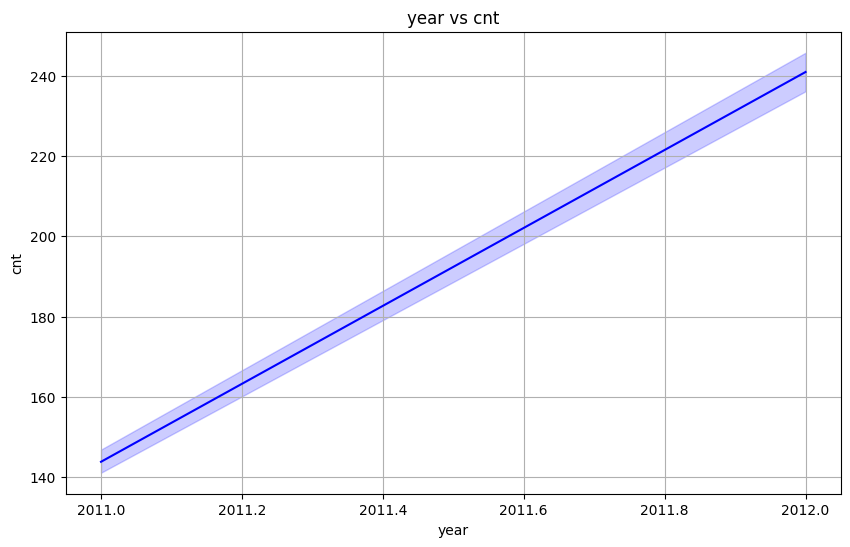

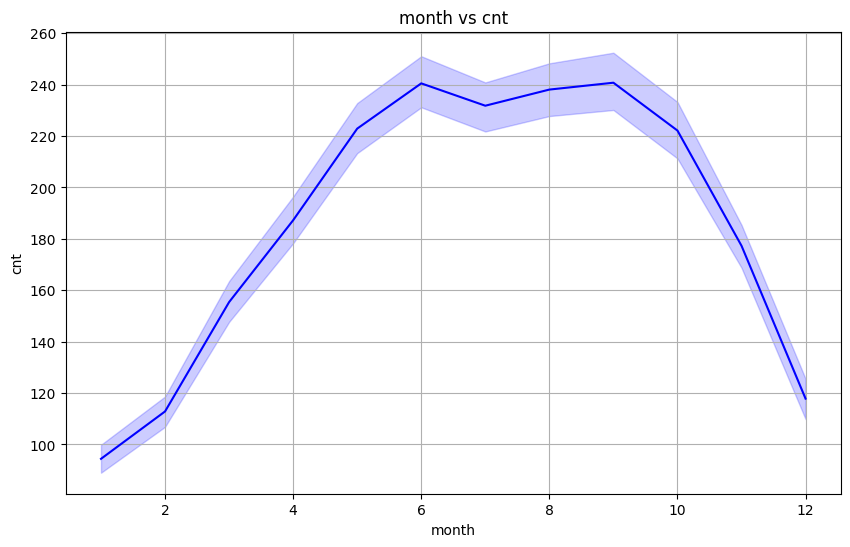

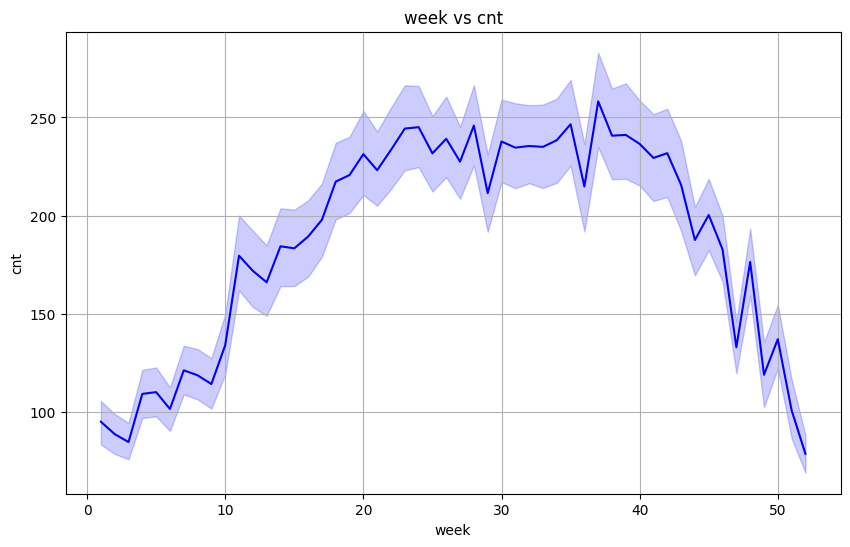

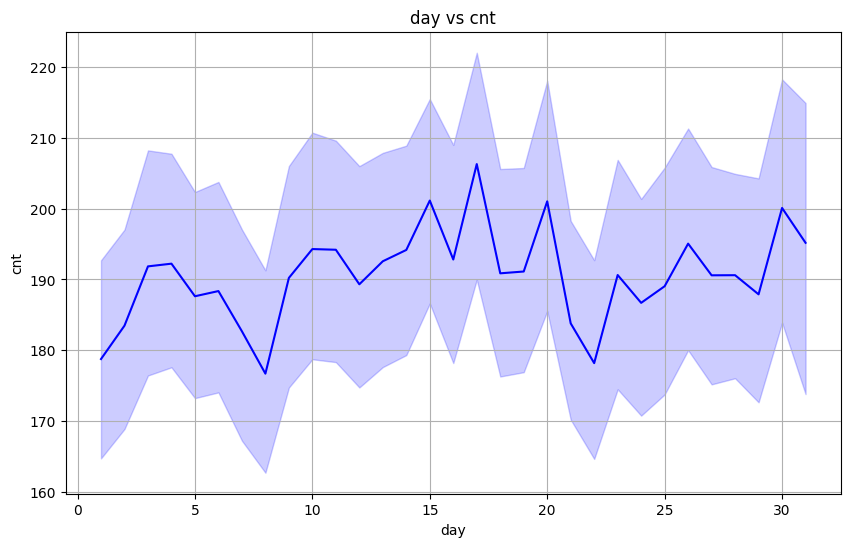

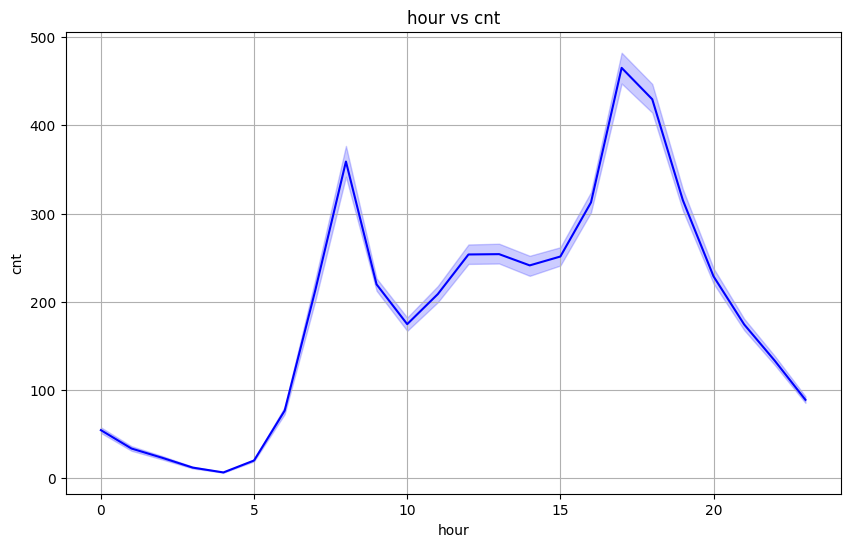

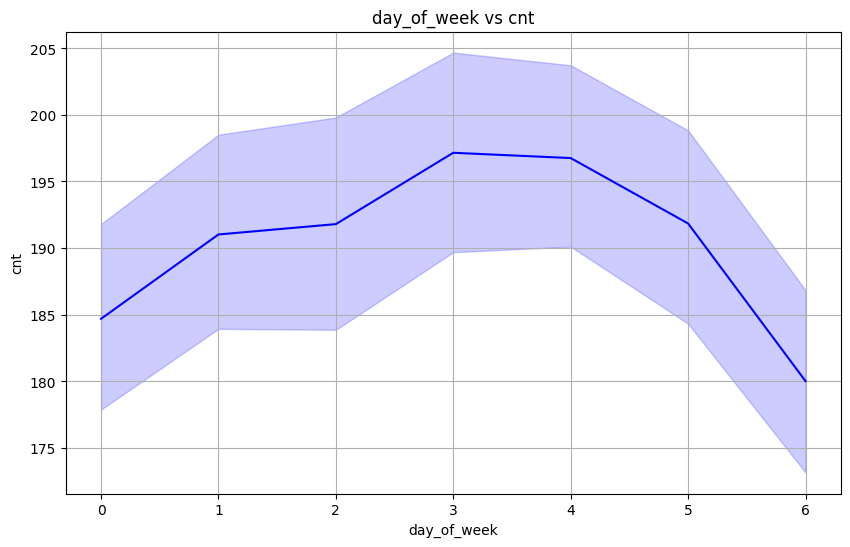

In [18]:
cols = ['year', 'month', 'week', 'day', 'hour', 'day_of_week']

for col in cols:
    dv_train.lineplot(x=col, y='cnt', title=f'{col} vs cnt', path=f'Figures/{col}_vs_cnt.png')

The analysis of the above plots reveals the following insights:  
- Over the two-year period, the average value of `cnt` has shown an upward trend. Since there is no real added value in this column since we are working over just two years, this column will be dropped  
- The monthly and weekly graphs demonstrate a distinct peak in `cnt` during the summer months. Since in both of the columns the same trends can be observed, the month column will be dropped.
- The day-of-the-month graph does not exhibit a clear correlation. Therefore, this column will be dropped.
- The hour-of-the-day graph shows pronounced peaks during the morning and evening hours.  
- The day-of-the-week graph indicates noticeable peaks on the fourth and fifth days of the week.

## 2.6 Stationarity

To assess whether the dataset exhibits stationarity, we will perform the Augmented Dickey-Fuller (ADF) test. This statistical test evaluates the null hypothesis ($H_0$) that the data contains a unit root, indicating non-stationarity. Rejection of the null hypothesis suggests that the data is stationary.

**Hypothesis:**

- $H_0$: The data contains a unit root and is non-stationary.
- $H_1$: The data does not contain a unit root and is stationary.

**Results:**

The outcome of the ADF test includes:
- The test statistic, which is compared against critical values at various significance levels (e.g., 1%, 5%, 10%).
- The p-value, indicating the probability of observing the test statistic under the null hypothesis.

Based on these results, we will determine if stationarity can be assumed for the dataset or if additional transformations (e.g., differencing) are necessary to achieve stationarity.


In [19]:
stat_tests = fc.StatisticalTests(train_data)

In [20]:
stat_tests.stationary_test('cnt')

ADF Statistic: -6.625164793721716
p-value: 5.901288668679553e-09
Critical Values: {'1%': -3.430744160906401, '5%': -2.8617142032973706, '10%': -2.5668627239973634}

Reject the null hypothesis, the data is stationary


## 2.7 Fourier analysis

**Fourier Transform (FT) in Time Series Analysis**

A Fourier Transform (FT) converts data from the time domain into the frequency domain *(Omar, 2021)*. This transformation is specifically applicable to periodic signals in a time series format. When multiple periodic signals are combined, it can become challenging to discern where each signal begins and ends. By applying an FT, a frequency-amplitude graph is generated, allowing these components to be clearly identified.


**Visualizing Periodic Signals with Inverse Fourier Transform (IFT)**

To observe the periodic signals in their original form, an Inverse Fourier Transform (IFT) can be applied. However, before performing the IFT, the Fourier-transformed data must be cleaned to avoid merely reproducing the original time-domain data. This concept is demonstrated through the following visualizations:

1. **Periodic Components**  
   ![Periodic components](Figures/Explanations/Periodic%20components.png)  
   *This figure visualizes the three individual components that constitute the data.*

2. **Combined Data and Fourier Transform**  
   ![Combined + decomposed](Figures/Explanations/Combined%20+%20decomp.png)  
   *This figure shows the combined data alongside its Fourier Transform, highlighting three peaks at frequencies 10, 120, and 360.*

3. **Low-Pass Filter**  
   ![Low pass filter](Figures/Explanations/Low%20pass%20filter.png)  
   *A low-pass filter is applied here to retain only the low-frequency signals.*

4. **High-Pass Filter**  
   ![High pass filter](Figures/Explanations/High%20pass%20filter.png)  
   *A high-pass filter is applied to remove low-frequency signals, preserving only the high-frequency components.*

5. **Bandstop Filter**  
   ![Banstop filter](Figures/Explanations/Bandstop%20filter.png)  
   *A bandstop filter is applied, filtering out medium-frequency signals while keeping the low and high-frequency components.*

6. **Bandpass Filter**  
   ![Bandpass filter](Figures/Explanations/Bandpass%20filter.png)  
   *A bandpass filter is applied, retaining only the medium-frequency signals.*

7. **Noisy Periodic Components**  
   ![Noise periodic components](Figures/Explanations/Noise%20periodic%20components.png)  
   *This figure visualizes the periodic components that form the data, which include significant noise.*

8. **Noisy Combined Data and Fourier Transform**  
   ![Noise combined + decomposed](Figures/Explanations/Noise%20combined%20+%20decomp.png)  
   *This figure shows the noisy combined data and its Fourier Transform. Many small peaks are visible, alongside two prominent peaks at frequencies 10 and 120.*

9. **Noise Filter**  
   ![Noise filter](Figures/Explanations/Noise%20filter.png)  
   *A noise filter is applied to remove low-amplitude peaks, ensuring only significant periodic components are retained.*


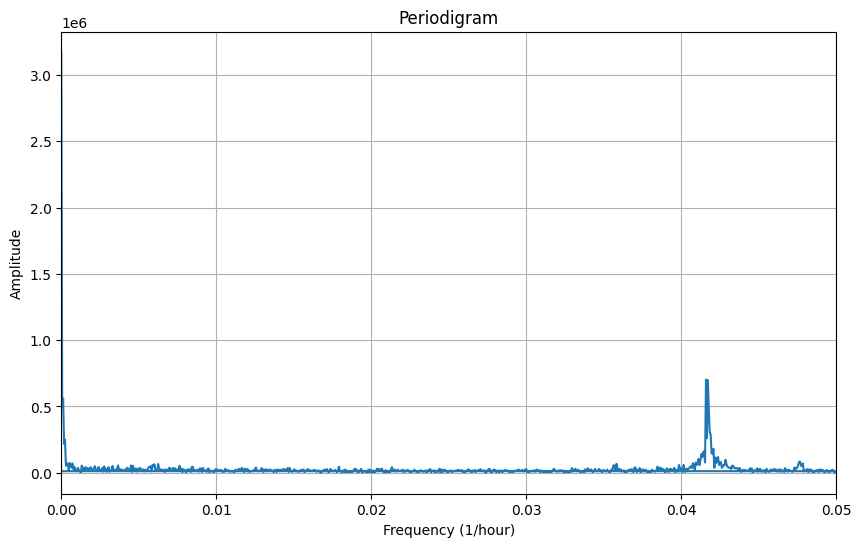

,amplitude,freq,duur in uren,duur in dagen
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859


In [21]:
stat_tests.fourier_analysis('cnt')

The Fourier analysis reveals two prominent frequency spikes:

1. A spike at a frequency of approximately **0.0001**, which corresponds to a periodicity of roughly **one year**.  
2. A second spike at a frequency of approximately **0.041**, which translates to a periodicity of approximately **24 hours**.

These findings suggest the presence of annual and daily patterns in the dataset, which may be significant for time series modeling. 

## 2.8 Autocorrelation

**Autocorrelation**

Autocorrelation represents the similarity between a time series and a lagged version of itself. It measures the relationship between the current value of a variable and its past values. The scale for autocorrelation is the same as for regular correlation:  
- **+1** indicates a perfect positive correlation,  
- **-1** indicates a perfect negative correlation, and  
- **0** indicates no correlation.  
*(Smith, 2024)*  

**Lagging**

Lagging refers to shifting the values of a variable backward or forward in time to create new features, known as lagged features. These lagged features capture temporal dependencies and trends in the data, which can enhance the accuracy of predictive models.  
*("Analyzing the Impact of Lagged Features in Time Series Forecasting: A Linear Regression Approach," 2024)*  


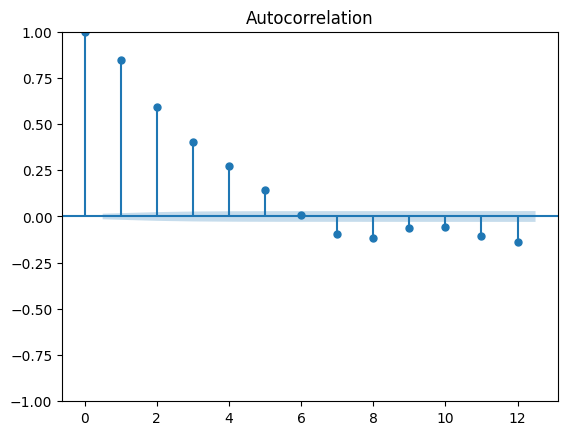

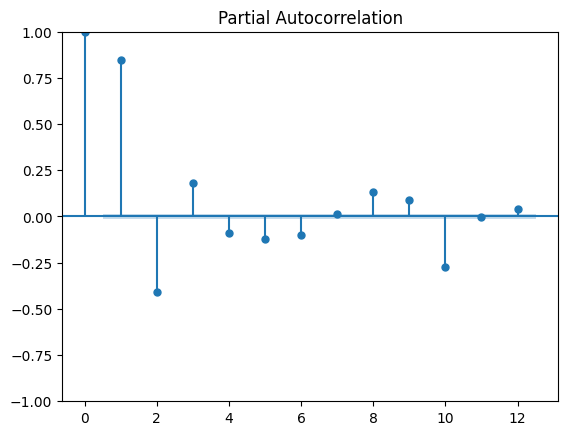

In [22]:
plot_acf(train_data['cnt'], lags=12, ax=plt.gca(), alpha=0.05)
plt.savefig('Figures/ACF.png')
plt.show()

plot_pacf(train_data['cnt'], lags=12, ax=plt.gca(), alpha=0.05)
plt.savefig('Figures/PACF.png')
plt.show()

Based on the combined autocorrelation and partial autocorrelation plots, we observe significant correlations up to **lag 5**. This indicates that past values within this lag range have a meaningful relationship with the current value, which may be important for time series modeling.

## 2.9 Conclusion

The exploratory data analysis (EDA) has provided valuable insights into the dataset, its structure, and the relationships between features. Based on the findings, the following data preprocessing steps will be applied to prepare the dataset for further analysis and modeling:

1. **Column Dropping**:
   - The following columns will be removed as they either lack meaningful contribution, exhibit high correlation with other features, or show redundant information:
     - `holiday`: Weak correlation with the target variable and limited predictive power.
     - `year`, `month`, `day_of_week`, `day`: These columns demonstrate trends or patterns already captured by other features, such as `hour` or aggregated time-series patterns.
     - `atemp`: Highly correlated with `temp` (0.99), making it redundant.
     - `windspeed`: Weak correlation with the target variable, indicating limited linear influence.

2. **Dummy Variable Creation**:
   - Dummy variables will be created for the `weathersit` column to capture its categorical nature effectively and ensure its compatibility with predictive modeling.

3. **Feature Engineering with Fourier Analysis**:
   - Fourier waves will be generated based on the following columns to capture their periodicity:
     - `week` (annual periodicity).
     - `hour` (daily periodicity).
   - After generating the Fourier waves, the original `week` and `hour` columns will be dropped.

4. **Indexing**:
   - The `date_hour` column will be converted to the `datetime` format and set as the index for the dataset to facilitate time series analysis.

These steps will ensure the dataset is optimized for modeling by retaining meaningful features, addressing redundancy, and incorporating temporal patterns effectively.


## 2.10 Updating `test_data`

**Adding Time Series Components to Testing Data**

During the Exploratory Data Analysis (EDA), time series-specific components were incorporated into the training data. To ensure that the models can generalize effectively, the testing data must match the structure of the training data. As a result, the same time series-specific components are now being added to the testing data.  


In [23]:
test_data = fc.create_timeseries_features(test_data)

# 3. Feature engineering

In [24]:
cols_to_drop = ['holiday', 'year', 'month', 'day_of_week', 'day', 'atemp', 'windspeed']
cols_to_dummy = ['weathersit']
cols_to_fourier = ['hour', 'week']
index_col = 'date_hour'

fe = fc.FeatureEngineering(train_data, test_data, cols_to_drop, cols_to_dummy, cols_to_fourier, index_col)

## 3.1 Dropping columns

From the Exploratory Data Analysis (EDA), the following decisions were made regarding dropping columns:

- The columns **['holiday', 'windspeed']** were found to have very low correlation with the target variable and will therefore be dropped.
- The time variables **['year', 'month', 'day_of_week', 'day']** were evaluated, and it was concluded that **'hour'** and **'week'** are the most relevant time-based features. Consequently, the other time variables will be dropped.
- The feature **'atemp'** was removed due to its high correlation with **'temp'**, as retaining both could lead to multicollinearity issues.

In [25]:
fe.drop_columns()

Dropping columns: ['holiday', 'year', 'month', 'day_of_week', 'day', 'atemp', 'windspeed']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_hour    16637 non-null  datetime64[ns]
 1   holiday      16637 non-null  int64         
 2   weathersit   16637 non-null  int64         
 3   temp         16637 non-null  float64       
 4   atemp        16637 non-null  float64       
 5   hum          16637 non-null  float64       
 6   windspeed    16637 non-null  float64       
 7   cnt          16637 non-null  int64         
 8   year         16637 non-null  int64         
 9   month        16637 non-null  int64         
 10  week         16637 non-null  int64         
 11  day          16637 non-null  int64         
 12  hour         16637 non-null  int64         
 13  day_of_week  16637 non-null  int64         
dtypes: datetime

## 3.2 Creating dummies

From the Exploratory Data Analysis (EDA), it was observed that the **'weathersit'** column contains four categorical values. Since categories do not have a continuous influence on the target variable, **dummy variables** were created to represent these categories.

In [26]:
fe.create_dummies()

Creating dummies for columns: ['weathersit']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   weathersit  16637 non-null  int64         
 2   temp        16637 non-null  float64       
 3   hum         16637 non-null  float64       
 4   cnt         16637 non-null  int64         
 5   week        16637 non-null  int64         
 6   hour        16637 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 910.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   456 non-null    datetime64[ns]
 1   weathersit  456 non-null    int64         
 2   temp        456 non-null    float64       


## 3.3 Creating fourier waves

**Creating Sinusoidal Features for Time-Based Variables**

From the Fourier Transform analysis, we identified a clear daily repeating pattern in the **'cnt'** column. To capture this pattern, we created sinusoidal features using the **'hour'** column, generating both sine and cosine functions. These functions create a perfect wave with a minimum value of -1 and a maximum value of +1. Similarly, a clear yearly pattern was observed, prompting the same transformation for the **'week'** column.

This transformation serves as a form of scaling, as both the **'hour'** and **'week'** columns now have a domain of $[-1, +1]$.


Creating Fourier waves for columns: ['hour', 'week']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_hour     16637 non-null  datetime64[ns]
 1   temp          16637 non-null  float64       
 2   hum           16637 non-null  float64       
 3   cnt           16637 non-null  int64         
 4   week          16637 non-null  int64         
 5   hour          16637 non-null  int64         
 6   weathersit_1  16637 non-null  uint8         
 7   weathersit_2  16637 non-null  uint8         
 8   weathersit_3  16637 non-null  uint8         
 9   weathersit_4  16637 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), int64(3), uint8(4)
memory usage: 845.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---

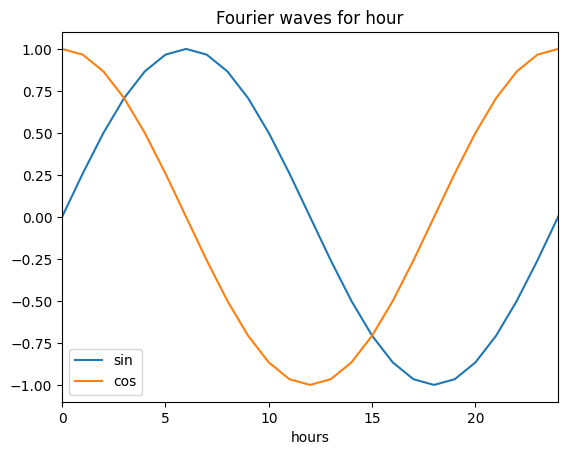

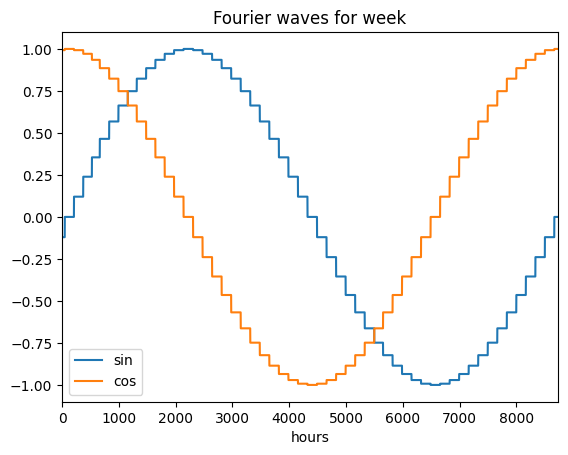

Fourier waves created
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_hour     16637 non-null  datetime64[ns]
 1   temp          16637 non-null  float64       
 2   hum           16637 non-null  float64       
 3   cnt           16637 non-null  int64         
 4   weathersit_1  16637 non-null  uint8         
 5   weathersit_2  16637 non-null  uint8         
 6   weathersit_3  16637 non-null  uint8         
 7   weathersit_4  16637 non-null  uint8         
 8   hour_sin      16637 non-null  float64       
 9   hour_cos      16637 non-null  float64       
 10  week_sin      16637 non-null  float64       
 11  week_cos      16637 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), uint8(4)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (tota

In [27]:
fe.fourier_wave()

## 3.4 Setting index

To ensure that the time series is modeled correctly, the **datetime** column will be set as the index of the dataset. This allows the models to leverage the temporal structure of the data for accurate predictions.

In [28]:
train_data, test_data = fe.set_index()

In [29]:
train_data.head()

,temp,hum,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,hour_sin,hour_cos,week_sin,week_cos
date_hour,,,,,,,,,,,
2011-01-01 00:00:00,0.24,0.81,16,1,0,0,0,0.000000,1.000000,-0.120537,0.992709
2011-01-01 01:00:00,0.22,0.80,40,1,0,0,0,0.258819,0.965926,-0.120537,0.992709
2011-01-01 02:00:00,0.22,0.80,32,1,0,0,0,0.500000,0.866025,-0.120537,0.992709
2011-01-01 03:00:00,0.24,0.75,13,1,0,0,0,0.707107,0.707107,-0.120537,0.992709
2011-01-01 04:00:00,0.24,0.75,1,1,0,0,0,0.866025,0.500000,-0.120537,0.992709


In [30]:
test_data.head()

,temp,hum,weathersit_1,weathersit_2,weathersit_3,hour_sin,hour_cos,week_sin,week_cos
date_hour,,,,,,,,,
2012-12-01 00:00:00,0.26,0.81,1,0,0,0.000000,1.000000,-0.568065,0.822984
2012-12-01 01:00:00,0.26,0.81,1,0,0,0.258819,0.965926,-0.568065,0.822984
2012-12-01 02:00:00,0.26,0.81,0,1,0,0.500000,0.866025,-0.568065,0.822984
2012-12-01 03:00:00,0.26,0.81,0,1,0,0.707107,0.707107,-0.568065,0.822984
2012-12-01 04:00:00,0.26,0.81,1,0,0,0.866025,0.500000,-0.568065,0.822984


In the training data, a dummy column named **`weathersit_4`** has been created, but it is absent in the test data. Since the **`weathersit`** variable takes values ranging from 1 to 4, the absence of **`weathersit_4`** in the test data indicates that this category is not represented. 

To ensure consistency between the training and test datasets, we can safely drop the **`weathersit_4`** column from the training data without any loss of information.

In [31]:
train_data.drop('weathersit_4', axis=1, inplace=True)

In [32]:
train_data.head()

,temp,hum,cnt,weathersit_1,weathersit_2,weathersit_3,hour_sin,hour_cos,week_sin,week_cos
date_hour,,,,,,,,,,
2011-01-01 00:00:00,0.24,0.81,16,1,0,0,0.000000,1.000000,-0.120537,0.992709
2011-01-01 01:00:00,0.22,0.80,40,1,0,0,0.258819,0.965926,-0.120537,0.992709
2011-01-01 02:00:00,0.22,0.80,32,1,0,0,0.500000,0.866025,-0.120537,0.992709
2011-01-01 03:00:00,0.24,0.75,13,1,0,0,0.707107,0.707107,-0.120537,0.992709
2011-01-01 04:00:00,0.24,0.75,1,1,0,0,0.866025,0.500000,-0.120537,0.992709


# 4. Modelling

## 4.1 Regular models

### 4.1.1 Linear Regression

**Linear Regression**

A **linear regression** model is an algorithm used to predict future outcomes based on a linear relationship between independent variables and a target variable.

![LinReg best fit](Figures/Explanations/LinReg%20best%20fit.png)  
*The figure above shows the best fit for a linear regression with only one independent variable (Kanade, 2023a).*

The general formula for linear regression is:

$$y(x) = p_0 + p_1x_1 + p_2x_2 + ... + p_{(n)}x_{(n)}$$

Where:
- **$y(x)$**: The predicted value for $y$ at moment $x$
- **$p_0$**: The intersection with the y-axis, or the value for $y$ when $x$ is 0
- **$p_t$**: The weights showing how much each variable contributes to the prediction
- **$x_t$**: The variable
- **$t$**: The number of variables

**Loss Function**

The **Root Mean Squared Error (RMSE)** or **Mean Squared Error (MSE)** score is typically used to assess the loss of the linear regression model. The output of the loss function is a single number representing the average squared difference between the actual and predicted values. The lower the number, the better the model's performance.

The formula for MSE is:

$$MSE = \frac{1}{N}\sum_{i = 1}^{n} (y_i - \hat{y_i})^2$$

Where:
- **$N$**: The number of observations
- **$y_i$**: The actual value for $y$
- **$\hat{y_i}$**: The predicted value for $y$  
- To calculate the RMSE, the square root of the MSE is taken

*(Kanade, 2023b)*

**Regularization**

**Regularization** techniques are applied to prevent overfitting, which occurs when the model becomes too closely aligned with the training data and performs poorly on new data. Regularization introduces a penalty to the residual sum of squares (RSS), discouraging the use of excessively large coefficients. The formula for the RSS is as follows:

$$ RSS = \sum_{i = 1}^{n} (y_i - (\beta_0 + \sum_{j = 1}^{p} \beta_jx_{ij}))^2 $$

Where:
- **$n$**: The total number of observations
- **$y_i$**: The actual value for $y$
- **$p$**: The total number of features
- **$\beta_j$**: The model's coefficients
- **$x_{ij}$**: The $i^{th}$ observation for the $j^{th}$ feature
- **$\beta_0 + \sum_{j = 1}^{p} \beta_jx_{ij}$**: The predicted output for each observation

**Types of Regularization**

- **L1 Regularization (Lasso)**:  
    Encourages sparsity by driving some coefficients to zero, thus performing feature selection.

- **L2 Regularization (Ridge)**:  
    Penalizes the squared values of coefficients, discouraging large coefficients and reducing model sensitivity to small changes in the input data.

*(Ansari, 2023)*

In [33]:
lr = LinearRegression()
param_grid = {'fit_intercept': [True, False], 'copy_X': [True, False]}

lr = fc.GridSearch(train_data, test_data, target='cnt', model=lr, param_grid=param_grid, n_splits=5, order=1)
lr.fit()
lr.predict(test_data_pred_col)
lr.to_csv(model='lr', path_add=f'order_1')

Best parameters: {'copy_X': True, 'fit_intercept': False}, Best score: -173.88225641633434


### 4.2 KNN Regressor

The k-Nearest Neighbors (kNN) Regressor algorithm predicts a continuous target variable based on the average values of the nearest neighbors. It operates by plotting all data points in a multi-dimensional space, where each point is associated with a specific target value. When a new test data point is introduced, the algorithm computes the distances to the K nearest neighbors. 

**Prediction Methods**

Once the distances to the K nearest neighbors are computed, the algorithm can make predictions using the following method:

1. **Average of Nearest Neighbors**: The predicted value for the test data point is determined by averaging the target values of the K nearest neighbors. This method assumes that the value of the target variable for a test point is closely related to the values of its nearest neighbors.

These methodologies ensure that the kNN Regressor algorithm provides a flexible and robust prediction mechanism for continuous datasets.

**Importance of Standardization**

The kNN Regressor uses distance to predict new values. This is effective as long as all features in the dataset have similar scales. If the features have different scales, those with larger values will dominate the distance metric. For example, if one feature is body height (measured in meters) and another is body weight (measured in kilograms), the distance metric will be skewed toward body weight unless both features are standardized. Without standardization, predictions can be heavily influenced by certain features, reducing the accuracy of the model.

Therefore, standardization improves accuracy and prevents bias by ensuring all features contribute equally to the distance calculation.

**Regularization in k-Nearest Neighbors (kNN Regressor)**

In machine learning, **regularization** is used to prevent overfitting by adding a penalty to complex models. However, for non-parametric models like k-Nearest Neighbors (kNN), regularization is handled differently since KNN does not fit a parametric function. Instead, it makes predictions based on the proximity of data points in the feature space. While KNN does not explicitly include regularization terms like in parametric models, certain parameters control model complexity and improve generalization.

**Key Regularization Aspects in KNN**

1. **Choice of K (Number of Neighbors)**:
   - The value of $K$ is crucial in controlling the **bias-variance trade-off**. A lower $K$ makes the model more sensitive to noise, as it focuses on fewer neighbors, leading to high variance and potential overfitting. A higher $K$ smooths the predictions, reducing variance but increasing bias, which can help prevent overfitting to training data.
   - Therefore, selecting an optimal $K$ acts as an implicit form of regularization, with smaller values favoring higher complexity and larger values enforcing smoother, generalized predictions.

**Regularization by Cross-Validation**
- **Cross-validation** can be used in conjunction with the choice of $K$ to find the optimal balance, effectively acting as a regularization process. By tuning $K$ to minimize overfitting and maximize predictive performance, cross-validation helps ensure generalization of the model.

In summary, while kNN does not explicitly apply regularization terms like in parametric models, the selection of $K$, feature scaling, and cross-validation all contribute to regularizing the model, controlling complexity, and improving generalization performance in kNN regression *(Baladram, 2024a)*.

In [34]:
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}

knn = fc.GridSearch(train_data, test_data, target='cnt', model=knn, param_grid=param_grid, n_splits=5, order=None)
knn.fit()
knn.predict(test_data_pred_col)
knn.to_csv(model='knn', path_add=f'order_None')

Best parameters: {'n_neighbors': 5, 'weights': 'distance'}, Best score: -168.82147640606235


### 4.3 Decision Tree Regressor

A Decision Tree Regressor is a non-parametric model used for regression tasks. It makes predictions by recursively partitioning the data into smaller subsets based on feature values. Each internal node in the tree corresponds to a decision made based on a specific feature, while each leaf node represents a predicted continuous outcome.

**Splitting Criteria**

The effectiveness of a Decision Tree Regressor hinges on the criteria used to determine the best splits. The most prevalent splitting criteria are:

1. **Mean Squared Error (MSE)**:  
   MSE quantifies the variance of the target variable within the node. When splitting a node, the algorithm chooses the feature and threshold that minimizes the MSE in the resulting child nodes. Lower MSE values indicate a better split, as they lead to purer nodes with smaller variance in the target variable.

2. **Mean Absolute Error (MAE)**:  
   MAE measures the average absolute differences between the predicted values and the actual target values. Like MSE, the algorithm seeks to minimize the MAE in the child nodes after a split, aiming for more accurate predictions.

**Pruning and Overfitting**

**Pruning** is a critical technique used to simplify the Decision Tree model by removing sections of the tree that do not contribute significantly to predictive power. This practice helps mitigate the risk of overfitting. Pruning can be categorized into two primary forms:

1. **Pre-Pruning (Early Stopping)**:  
   Pre-pruning involves halting the growth of the tree before it reaches its maximum depth. This can be achieved by imposing constraints such as limiting the depth of the tree, setting a minimum number of samples required to perform a split, or requiring a minimum number of samples at a leaf node. These measures prevent the model from becoming overly complex and prone to overfitting.

2. **Post-Pruning**:  
   In this approach, the tree is fully grown before assessing its structure. Post-pruning entails the removal of branches that contribute minimally to the model's performance. This is accomplished by evaluating the tree's performance on validation data and eliminating branches that do not enhance generalization.

*Considerations for Pruning*

While pruning is effective for reducing overfitting, it is crucial to avoid excessive pruning, as this can lead to **underfitting**. Underfitting occurs when the tree is overly simplistic and fails to capture the underlying patterns in the data, thereby impairing the model’s ability to make accurate predictions *(Baladram, 2024b)*.


In [35]:
dt = DecisionTreeRegressor()
param_grid = {'max_depth': [1, 2, 3, 4, 5], 'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

dt = fc.GridSearch(train_data, test_data, target='cnt', model=dt, param_grid=param_grid, n_splits=5, order=1)
dt.fit()
dt.predict(test_data_pred_col)
dt.to_csv(model='dt', path_add=f'order_1')

Best parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}, Best score: -142.96085800819353


### 4.4 Random Forest Regressor

Random Forest (RF) Regressor is an ensemble learning technique that constructs multiple decision trees and aggregates their individual predictions to create a more robust model, referred to as a "forest." The primary method used to build each decision tree in a Random Forest is known as **bagging** (Bootstrap Aggregating).

**Bagging Process**

In the context of a Random Forest Regressor, bagging involves training each decision tree independently using a random sample of the training dataset. This sampling is done with replacement, allowing some observations to be included multiple times, while others may be excluded. The final prediction is made by averaging the predictions from all individual trees, which helps to reduce variance and improve accuracy.

*Feature Randomization*

In addition to random sampling of the data, Random Forest enhances the diversity of the individual trees by randomly selecting a subset of features to consider at each split in the decision tree. This randomness in feature selection reduces the correlation among the trees, which improves the model's accuracy and generalization ability. The ability to use different subsets of features in each tree helps Random Forest to effectively handle complex data with many features.

The combination of bagging and feature randomization makes Random Forest a powerful and versatile machine learning algorithm, capable of effectively handling large datasets and complex relationships between features.

**Training Time**

The training time for a Random Forest Regressor is relatively short because the individual trees can be trained in parallel. Since each tree is trained independently, it is possible to leverage multi-core processors to train the trees simultaneously, further speeding up the process (Beheshti, 2022).


In [36]:
rf = RandomForestRegressor()
param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 2, 3, 4, 5],'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

rf = fc.GridSearch(train_data, test_data, target='cnt', model=rf, param_grid=param_grid, n_splits=5, order=1)
rf.fit()
rf.predict(test_data_pred_col)
rf.to_csv(model='rf', path_add=f'order_1')

Best parameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 50}, Best score: -131.36885791005471


### 4.5 XGB Regressor

XGBoost (Extreme Gradient Boosting) Regressor is an optimized implementation of the Gradient Boosting (GB) framework. While it retains the core principle of boosting—where each new tree is trained to correct the errors made by its predecessors—XGBoost introduces several enhancements that improve its performance and flexibility for regression tasks.

**Key Improvements**

1. **Regularization**:  
   XGBoost incorporates both L1 (Lasso) and L2 (Ridge) regularization techniques, which help reduce overfitting by penalizing the complexity of the model. This regularization can lead to better generalization on unseen data, particularly when the model has many features or is prone to overfitting.

2. **Handling of Weighted and Missing Data**:  
   XGBoost provides robust mechanisms for managing weighted data points and effectively dealing with missing values. This allows the model to handle incomplete datasets and adjust for the importance of individual observations during training, making it more flexible in real-world scenarios where missing or unbalanced data is common.

3. **Tree Pruning**:  
   XGBoost uses a technique called "max depth pruning" that helps to prevent overfitting by optimizing the depth of trees during the training process. This allows XGBoost to build efficient and accurate regression models with smaller, more relevant trees.

Through these optimizations, XGBoost achieves significant improvements in computational efficiency, flexibility, and predictive accuracy, making it a popular choice for a wide range of regression tasks in machine learning.

**Training Time**

The trees in an XGBoost model are built sequentially because each newly built tree is based on the output of the prior tree. However, XGBoost is not strictly sequential. While it still builds each tree sequentially, the construction of individual trees is optimized. For example, the search for the best split is parallelized, with feature evaluations distributed across multiple processors. This "hybrid" approach reduces the training time of an XGBoost model compared to traditional Gradient Boosting models, making it much faster for large datasets (Omarzai, 2024).

In [37]:
xgb = XGBRegressor()
param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0], 'subsample': [0.01, 0.1, 0.3, 0.5, 0.7, 1], 'colsample_bytree': [0.01, 0.1, 0.3, 0.5, 0.7, 1]}

xgb = fc.GridSearch(train_data, test_data, target='cnt', model=xgb, param_grid=param_grid, n_splits=5, order=1)
xgb.fit()
xgb.predict(test_data_pred_col)
xgb.to_csv(model='xgb', path_add=f'order_1')

Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}, Best score: -121.47544112453443


### 4.6 Self made ensemble

A **voting regressor** is an ensemble learning technique that combines predictions from multiple models to produce a more robust and accurate forecast. Each model within the ensemble contributes to the final prediction by providing its output.

The **voting regressor** calculates the mean of the predictions made by all individual models, resulting in the ensemble's final prediction.

The prediction, $y_{pred}$, is computed as follows:

$$
y_{pred} = \sum_{i=1}^{N} \frac{pred_{i}}{N}
$$

Where:
- **$i$**: Denotes each individual model in the ensemble,
- **$N$**: Represents the total number of models in the ensemble,
- **$pred_{i}$**: The prediction made by model $i$,
- **$y_{pred}$**: The final averaged prediction made by the voting regressor.

This method enhances performance by leveraging the diversity of predictions from different models, improving the ensemble's robustness and generalization capabilities *(Salunke, 2024)*.

For our ensemble, we selected the following models: **Decision Tree Regressor (DTR)**, **Random Forest Regressor (RFR)**, and **XGBoost Regressor (XGBR)**. Each model was chosen based on its unique strengths to create a balanced and effective ensemble:

- **Decision Tree Regressor (DTR):**  
  - Advantages: Requires relatively little computational power and is highly interpretable.  
  - Drawbacks: Prone to overfitting, especially with complex datasets.

- **Random Forest Regressor (RFR):**  
  - Advantages: Excellent at handling noise and generalizing, which compensates for the overfitting tendency of DTR.

- **XGBoost Regressor (XGBR):**  
  - Advantages: Provides a good balance between performance and computational speed, making it efficient for larger datasets.

By combining these models, the ensemble capitalizes on their respective strengths while mitigating individual weaknesses, resulting in a more robust and versatile model *(Galicia et al., 2018)*.

In [38]:
models = [('dt', dt.best_estimator), ('rf', rf.best_estimator), ('xgb', xgb.best_estimator)]

sme = fc.SelfMadeEnsemble(train_data, test_data, 'cnt', models)
sme.fit()
sme.predict(test_data_pred_col)
sme.to_csv()

Following the initial evaluation of all models:  

- **Order 1 and Order 2** models performed significantly better than the model with no order.  
- The difference in performance between **Order 1** and **Order 2** models was negligible.  
- For the **KNN model**, however, the model with **no order** yielded the best performance.  

As a result, we will proceed with **Order 1** for all subsequent analyses to maintain simplicity without sacrificing accuracy, except for the **KNN model**, where we will use **no order**.

### 4.1.4 Deciding feature importances

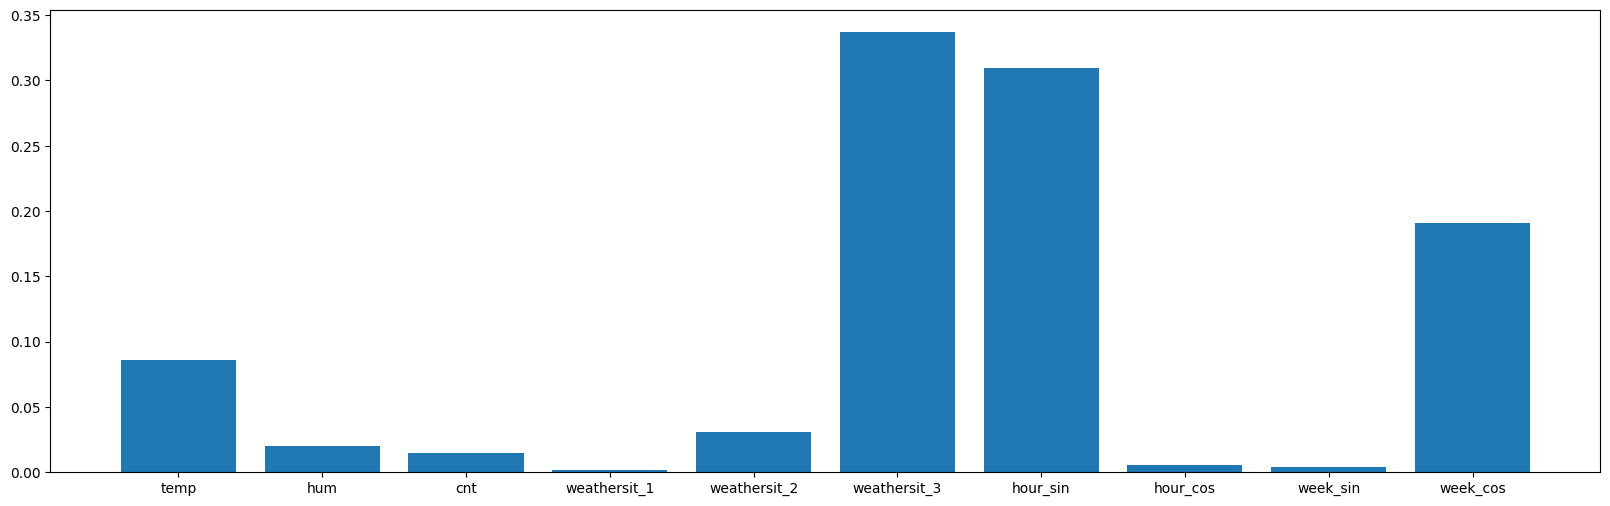

In [49]:
feature_importances = pd.DataFrame({'Feature': train_data.columns, 'dt': dt.best_estimator.feature_importances_, 'rf': rf.best_estimator.feature_importances_, 'xgb': xgb.best_estimator.feature_importances_})
feature_importances['mean_importance'] = feature_importances.mean(axis=1)


plt.figure(figsize=(20, 6))
plt.bar(feature_importances['Feature'], feature_importances['mean_importance'])
plt.savefig('Figures/feature_importances.png')
plt.show()

## 4.2 Timeseries models

### 4.2.1 SARIMAX

A **SARIMAX** model is an advanced time series forecasting model that combines components from several models, primarily the ARIMA model, while also accounting for seasonality and exogenous variables. The name stands for **Seasonal AutoRegressive Integrated Moving Average with eXogenous variables**. SARIMAX is particularly effective for forecasting trends and seasonal variations in time series data.

**Components of SARIMAX**

*ARIMA: The Core of SARIMAX*

The foundation of SARIMAX lies in the ARIMA model, which consists of three primary components:

1. **Autoregression (AR):**  
   This component uses past values of the time series to predict current values. Predictions are made by performing a linear regression on the last $p$ values of the series, where $p$ indicates the number of lagged observations to include.

2. **Moving Average (MA):**  
   The MA component addresses the errors from previous predictions. It performs a linear regression on the last $q$ residuals (errors) to improve the current prediction, where $q$ specifies the number of lagged errors to consider.

3. **Integration (I):**  
   Integration transforms the time series into a stationary series, which is a prerequisite for ARMA models (the combination of AR and MA). Stationarity is achieved by applying differencing to remove trends and seasonality, making the data suitable for modeling.

*Additional Components in SARIMAX*

4. **Seasonality (S):**  
   The model captures patterns that repeat at fixed intervals (e.g., daily, weekly, or yearly cycles). This enhances the model's ability to account for periodic variations in the data.

5. **Exogenous Variables (X):**  
   SARIMAX incorporates external predictors that may influence the target variable. By accounting for these exogenous factors, the model improves its forecasting accuracy by considering additional influences beyond the intrinsic time series patterns.

*(Melanie, 2024b)*

In [51]:
y = train_data['cnt']

param_grid = {'order': [(2, 0, 1)],
              'seasonal_order': [(2, 0, 1, 24)]}

sarimax_model = fc.SARIMAXModel(train_data, test_data, param_grid)
sarimax_model.grid_search()

sarimax_model.predict(test_data_pred_col)

sarimax_model.save_predictions()

GridSearch iterations:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
GridSearch iterations: 100%|██████████| 1/1 [09:21<00:00, 561.33s/it]

Best params: {'order': (2, 0, 1), 'seasonal_order': (2, 0, 1, 24)}
Best score: 60.05523372949227



c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 4.2.2 Prophet

While ARIMA models can be challenging to parameterize, **Prophet** offers a simpler and more flexible approach to time series forecasting. Prophet is designed to handle a wide range of time series data and uses **additive decomposition** (as previously explained) to generate forecasts.  

Key components of Prophet's model:

1. **Trend:**  
   The trend component allows for the identification of long-term patterns in the data, enabling reliable long-term forecasting.

2. **Seasonality:**  
   The seasonality component captures periodic variations, making it effective for forecasting repeating patterns over regular intervals.  
*(Melanie, 2024a)*  


In [52]:
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'yearly_seasonality': ['auto', True, False],
              'weekly_seasonality': ['auto', True, False],
              'daily_seasonality': ['auto', True, False]}

prophet_model = fc.ProphetModel(train_data, test_data, param_grid=param_grid)
prophet_model.grid_search()

prophet_model.predict()

prophet_model.save_predictions()

GridSearch iterations:   0%|          | 0/162 [00:00<?, ?it/s]21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:47 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   1%|          | 1/162 [00:03<09:49,  3.66s/it]21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   1%|          | 2/162 [00:08<11:27,  4.30s/it]21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:54 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   2%|▏         | 3/162 [00:11<09:52,  3.73s/it]21:23:56 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   2%|▏         | 4/162 [00:14<08:36,  3.27s/it]21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:02 - cmdstanpy - INFO - Chain [1] done processing
GridSearch iterations:   3%|▎         | 5/162 [00:18<09:52,  3.78s/it]21:24:03 - cmdstanpy - 

Best params: {'changepoint_prior_scale': 0.1, 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'weekly_seasonality': False, 'yearly_seasonality': True}
Best score: 111.27626485670837


## 4.2 Hybrid model

A **hybrid model** utilizes two different models to improve prediction accuracy by addressing residual errors. The process involves making two sequential predictions:

1. **First Prediction:**  
   The first model predicts the target variable based on the training data.

   ```python
   pred_1 = model1.fit(X_train, y_train)
   ```
2. **Residual Calculation:**
   Residuals are calculated as the difference between the actual values and the first model's predictions.

   ```python
   resid = y - pred_1
   ````
3. **Second Prediction:**
   The second model predicts the residuals from the first model.

   ```python
   pred_2 = model2.fit(X_train, resid)
   ```
4. **Final prediction:**
   The actual prediction combines the outputs from the two models by adding the first prediction to the second.

   ```python
   actual_pred = pred_1 + pred_2
   ```

This approach improves the model's performance by leveraging the second model to account for errors missed by the first, thereby enhancing overall predictive accuracy (Ryanholbrook, 2023).

In [53]:
hm = fc.HybridModel(train_data, test_data, 'cnt', {'lr': LinearRegression(), 'dt': DecisionTreeRegressor()})
hm.fit()
hm.predict(test_data_pred_col)
hm.save_predictions()

cnt prediction RMSE: 136.43251912104586
residual prediction RMSE: 136.43251912104586
total prediction RMSE: 19.30071265954488


# 5. Findings

Unfortunately, the results of our experiments have not been optimal. Due to the high runtime of the models and the limited time available, we were only able to run each model twice. Despite this limitation, the **XGBoost Regressor** emerged as the best-performing model with the following parameters:

- **colsample_bytree:** 1  
- **learning_rate:** 0.3  
- **max_depth:** 5  
- **n_estimators:** 100  
- **subsample:** 1  
- **deterministic order:** 1  

These hyperparameters indicate a well-balanced model configuration, though additional iterations and tuning might further improve performance given more time and computational resources.

# 6. Conclusion

**Feature Importance and Recommendations**

The feature importance plot below highlights that **weathersituation**, **hour**, and **week** have the most significant influence on the model's predictions:

![Feature Importance](Figures/feature_importances.png)

Based on this analysis, we recommend that the rental company focus on the following factors when forecasting rental demand:  

1. **Weathersituation:**  
   Monitor the predicted weather conditions, as they play a critical role in rental patterns.  

2. **Week:**  
   Consider the specific week, as seasonal variations can significantly impact demand.  

3. **Hour:**  
   Pay attention to the time of day, as it influences short-term rental fluctuations.

The most accurate forecasts can be achieved using the **XGBoost Regressor**, which demonstrated the best performance in our analysis.


# 7. References

1. Analyzing the impact of lagged features in time Series Forecasting: A Linear Regression approach. (2024, March 19). Cubed. Retrieved December 1, 2024, from https://cubed.run/blog/analyzing-the-impact-of-lagged-features-in-time-series-forecasting-a-linear-regression-approach-730aaa99dfd6 
2. Ansari, Y. (2023, February 15). *Regularized Linear Regression - Yahya Ansari - Medium*. Medium. Retrieved December 1, 2024, from https://medium.com/@novus_afk/regularized-linear-regression-35d5eaaa84d5 
3. Baladram, S. (2024a, November 30). *K Nearest neighbor regressor | Towards data science*. Medium. Retrieved December 1, 2024, from https://towardsdatascience.com/k-nearest-neighbor-regressor-explained-a-visual-guide-with-code-examples-df5052c8c889 
4. Baladram, S. (2024b, November 30). *Regression Tree | towards Data science*. Medium. Retrieved December 1, 2024, from https://towardsdatascience.com/decision-tree-regressor-explained-a-visual-guide-with-code-examples-fbd2836c3bef 
5. Beheshti, N. (2022, March 5). *Random Forest regression - towards data science*. Medium. Retrieved December 1, 2024, from https://towardsdatascience.com/random-forest-regression-5f605132d19d 
6. Dey, R. (2024, January 14). *Time Series Decomposition - Roshmita Dey - medium*. Medium. Retrieved December 1, 2024, from https://medium.com/@roshmitadey/time-series-decomposition-62cbf31ab65e 
7. Galicia, A., Talavera-Llames, R., Troncoso, A., Koprinska, I., & Martínez-Álvarez, F. (2018). *Multi-step forecasting for big data time series based on ensemble learning. Knowledge-Based Systems, 163, 830–841*. https://doi.org/10.1016/j.knosys.2018.10.009 
8. Hyndman, R. J., & Athanasopoulos, G. (2018, April). *6.1 Time series components | Forecasting: Principles and Practice (2nd ed)*. Retrieved December 1, 2024, from https://otexts.com/fpp2/components.html 
9. Kanade, V. (2023a, April 3). *Best Fit Line for a Linear Regression Model*. Spiceworks. https://images.spiceworks.com/wp-content/uploads/2022/04/07040338/25-4.png 
10. Kanade, V. (2023b, April 3). *What is Linear Regression?- Spiceworks*. Spiceworks Inc. Retrieved December 1, 2024, from https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-linear-regression/ 
11. Melanie. (2024a, February 27). *Facebook Prophet : All you need to know*. Data Science Courses | DataScientest. Retrieved December 1, 2024, from https://datascientest.com/en/facebook-prophet-all-you-need-to-know 
12. Melanie. (2024b, March 14). *SARIMAX model: What is it? How can it be applied to time series?* Data Science Courses | DataScientest. Retrieved December 1, 2024, from https://datascientest.com/en/sarimax-model-what-is-it-how-can-it-be-applied-to-time-series 
13. Omar, K. (2021, December 13). *Deconstructing Time Series using Fourier Transform - Khairul Omar - Medium*. Medium. Retrieved December 1, 2024, from https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e 
14. Omarzai, F. (2024, November 20). *XGBOOST Regression in depth - Fraidoon Omarzai - medium*. Medium. Retrieved December 1, 2024, from https://medium.com/@fraidoonomarzai99/xgboost-regression-in-depth-cb2b3f623281 
15. Ryanholbrook. (2023, April 20). *Hybrid models*. Kaggle. Retrieved December 1, 2024, from https://www.kaggle.com/code/ryanholbrook/hybrid-models 
16. Salunke, M. (2024, November 25). *Voting regressor: Intuition and Implementation - data and beyond - medium*. Medium. Retrieved December 1, 2024, from https://medium.com/data-and-beyond/voting-regressor-intuition-and-implementation-0359771b5204 
17. Smith, T. (2024, September 10). *Autocorrelation: what it is, how it works, tests*. Investopedia. Retrieved December 1, 2024, from https://www.investopedia.com/terms/a/autocorrelation.asp